## Import libs, set paths and load params

In [3]:
import os, glob
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, "../src")
import auxilary_functions as f
import subprocess
import csv
import matplotlib.pyplot as plt
import json

cfg = f.get_actual_parametrization("../src/config-yeast.json")
networks = ['gnw','networkx','fflatt']
organisms = ['yeast']

sizes = ['500', '750', '1000', '1500']
n_trials = 10

os.chdir('../networks/')
gnwdir = '/home/erikz/sonnhammer/gnw/'
fflattdir = '../snippets/'

print(os.getcwd())
topology_dir = os.path.join(os.getcwd(), 'topology')

/home/erik/sweden/sonnhammer/GeneSnake/generation/network_generation_algo/networks


In [4]:
#collect data
topo_list = []
for network in networks:
    for number, organism in enumerate(organisms):
        for size in sizes:
            current_dir = os.path.join(topology_dir, network, organism, size)
            #create networks if don't exist
            if not os.path.exists(os.path.abspath(current_dir)):
                
                try:
                    print('making dirs...')
                    os.mkdir(os.path.abspath(current_dir))
                        
                except FileExistsError:
                    pass
                
                if network == 'gnw':
                    
                    print('running gnw...')
                    subprocess.call(['java', '-jar', gnwdir+'gnw-3.1.2b.jar', '--extract', '--input-net',\
                         gnwdir+'sandbox/yeast_network.tsv',\
                        '--random-seed', '--greedy-selection', '--subnet-size='+str(size),\
                        '--num-subnets='+str(n_trials), '--output-net-format=0', '--keep-self-interactions',\
                        '-c', gnwdir+'sandbox/settings.txt', '--output-path',\
                        str(current_dir)])
                 
                elif network == 'networkx':
                    
                    print('creating scale-free networkx graphs...')       
                    f.create_nx_network(n_trials,cfg['SPARSITY'],size,current_dir)
                
                elif network == 'fflatt':
                    
                    print('running fflatt...')
                    #python3 test.py 103 0.4 test_networks/
                    subprocess.call(['python3', fflattdir+'test.py', json.dumps(cfg), size,\
                        str(n_trials), str(current_dir)])
                
                
                for rep, file in enumerate(glob.glob(os.path.join(current_dir, '*sv'))):
                    topo_list.append(f.analyze_exctracted_network(cfg, file, network, rep, size))
            
            #collect data otherwise
            else:
                for rep, file in enumerate(glob.glob(os.path.join(current_dir, '*sv'))):
                    topo_list.append(f.analyze_exctracted_network(cfg, file, network, rep, size))



making dirs...
running fflatt...
making dirs...
running fflatt...
making dirs...
running fflatt...
making dirs...
running fflatt...


In [5]:
df_topo = pd.DataFrame(topo_list, columns = ['ffl-nodes', 'sparsity', 'in-degree',\
                                             'out-degree', 'network', 'size', 'rep'])
df_topo["size"] = pd.to_numeric(df_topo["size"])
os.chdir('../results/tables')
df_topo.to_csv('topology_stats_yeast.tsv')

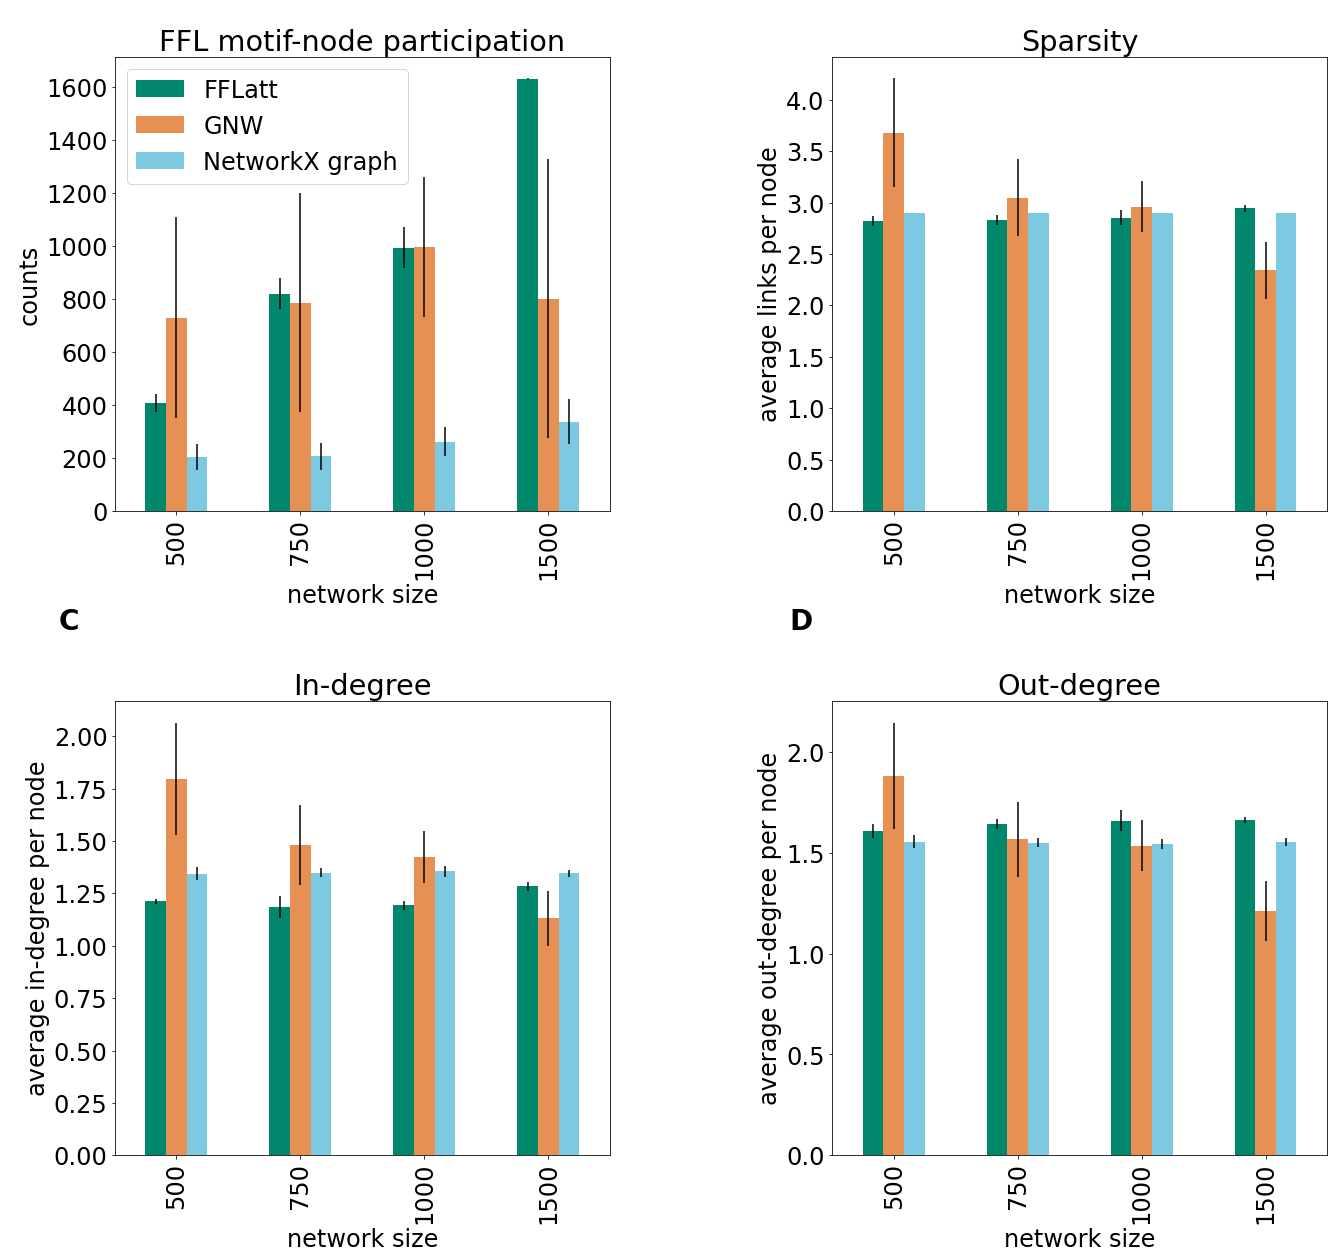

In [6]:
tool_colors = ['#00876c', '#e79053','#7dc9e1']
plt.rcParams.update({'font.size': 24})
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.tight_layout(pad=0.07)

in_degree = df_topo[['size','in-degree', 'network']]
in_degree.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "in-degree", legend = False,\
         yerr = np.ravel(in_degree.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax3, cmap='Dark2', figsize = (20,18), title = 'In-degree', color=tool_colors, xlabel = 'network size')

out_degree = df_topo[['out-degree', 'network', 'size']]
out_degree.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "out-degree", legend = False,\
         yerr = np.ravel(out_degree.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax4, cmap='Dark2', figsize = (20,18), title = 'Out-degree', color=tool_colors, xlabel = 'network size')

sparsity = df_topo[['sparsity', 'network', 'size']]
sparsity.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "sparsity", legend = False,\
         yerr = np.ravel(sparsity.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax2, cmap='Dark2', figsize = (20,18), title = 'Sparsity', color=tool_colors, xlabel = 'network size')

ffl_nodes = df_topo[['ffl-nodes', 'network', 'size']]
ffl_nodes.groupby(["network", "size"]).agg(np.mean).unstack(0).\
    plot(kind = "bar", y = "ffl-nodes", legend = False,\
         yerr = np.ravel(ffl_nodes.groupby(["network", "size"]).agg(np.std)).reshape(len(networks),len(sizes)),\
         ax=ax1, cmap='Dark2', figsize = (20,18), title = 'FFL motif-node participation', color=tool_colors,\
         xlabel = 'network size')

ax1.legend(["FFLatt", "GNW", "NetworkX graph"])
ax1.set_ylabel('counts')
ax2.set_ylabel('average links per node')
ax3.set_ylabel('average in-degree per node')
ax4.set_ylabel('average out-degree per node')

for ax, ylabel in zip([ax1, ax2, ax3, ax4], ['counts', 'average links per node',\
    'average in-degree per node', 'average out-degree per node']):
    ax.set_ylabel(ylabel)

#fig.canvas.draw()

for ax, label in zip([ax1, ax2, ax3, ax4], ['A', 'B', 'C', 'D']):
    bbox = ax.get_tightbbox(fig.canvas.get_renderer())
    fig.text(bbox.x0, bbox.y1, label, fontsize=28, fontweight="bold", ha="center",
             transform=None)

os.chdir('../figures/')
plt.savefig("figureS1_yeast.svg")
plt.savefig("figureS1_yeast.png")